In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt
from matplotlib import image as img

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

from sklearn.model_selection import train_test_split
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# set all dir
data_dir = "../input/aerial-cactus-identification"            # main dir
train_dir = data_dir + "/train/train"                         # train images folder
test_dir = data_dir + "/test/test"                            # test images folder

In [3]:
# read train csv
data = pd.read_csv(data_dir + "/train.csv")
data.head()                                                   # test csv

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
# check ratio of images with cactus and without cactus
data["has_cactus"].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

Text(0.5, 1.0, 'Number of Images has cactus {1} and without cactus')

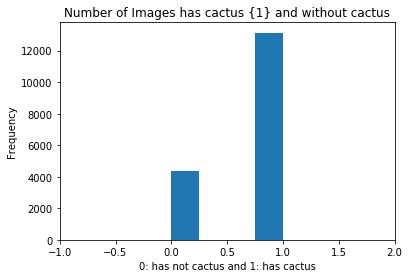

In [5]:
# visualize ratio of images with cactus and without cactus
plt.hist(data.has_cactus,align='mid',bins=4)
plt.xlim(-1, 2)
plt.xlabel("0: has not cactus and 1: has cactus")
plt.ylabel("Frequency")
plt.title("Number of Images has cactus {1} and without cactus")

In [6]:
# inherit Dataset and make changes as we access images through index latter
class cactData(Dataset):
    def __init__(self, split_data, data_root = './', transform = None):
        super().__init__()
        self.df = split_data.values                           # set dataframe
        self.data_root = data_root                            # images path
        self.transform = transform                            # transform

    def __len__(self):
        return len(self.df)                                   # return total length of dataframe 
    
    def __getitem__(self, index):
        img_name,label = self.df[index]                       # get image id and label from csv
        img_path = os.path.join(self.data_root, img_name)     # set image path
        image = img.imread(img_path)                          # read image from given image path
        if self.transform is not None:                        # transform image if transform available 
            image = self.transform(image)
        return image, label                                   # return image and image label

In [7]:
# split data into train and validation set; so training data = 80% and validation data = 20%
train, valid = train_test_split(data, stratify=data.has_cactus, test_size = 0.2)

In [8]:
# define transforms
train_transf = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor()])

valid_transf = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor()])

In [9]:
#  batch size 
batch_size = 128

In [10]:
# set cactData cons
train_data = cactData(train, train_dir, train_transf)
valid_data = cactData(valid, train_dir, valid_transf)

# get training and validation data
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size//2, shuffle=False)

In [11]:
# test data
images, labels = next(iter(train_loader))
images[0], labels[0]

(tensor([[[0.3569, 0.3608, 0.3725,  ..., 0.4667, 0.5216, 0.5333],
          [0.3843, 0.3882, 0.4000,  ..., 0.5686, 0.6157, 0.5137],
          [0.3961, 0.4000, 0.4000,  ..., 0.6000, 0.6902, 0.5373],
          ...,
          [0.4784, 0.4471, 0.3804,  ..., 0.4039, 0.4000, 0.3412],
          [0.4863, 0.4353, 0.3765,  ..., 0.3843, 0.4275, 0.3686],
          [0.4824, 0.4353, 0.3922,  ..., 0.4196, 0.4745, 0.4353]],
 
         [[0.3098, 0.3137, 0.3255,  ..., 0.3725, 0.4275, 0.4392],
          [0.3373, 0.3412, 0.3529,  ..., 0.4745, 0.5216, 0.4196],
          [0.3490, 0.3529, 0.3529,  ..., 0.5176, 0.5961, 0.4431],
          ...,
          [0.4275, 0.3961, 0.3294,  ..., 0.3451, 0.3412, 0.2824],
          [0.4353, 0.3843, 0.3255,  ..., 0.3255, 0.3686, 0.3098],
          [0.4314, 0.3843, 0.3412,  ..., 0.3608, 0.4157, 0.3765]],
 
         [[0.2627, 0.2667, 0.2784,  ..., 0.3569, 0.4196, 0.4314],
          [0.2902, 0.2941, 0.3059,  ..., 0.4588, 0.5137, 0.4118],
          [0.3020, 0.3059, 0.3059,  ...,

In [12]:
# define CNN model
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional Neural Networks
        self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
        
        # fully connected network
        self.fc1 = nn.Linear(1280, 640)
        self.fc2 = nn.Linear(640, 2)
        
        # pooling and dropout layer
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # reshape to fit into fully connected net
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return x

In [13]:
# set hyper parameters
num_epochs = 20
learning_rate = 0.01
momentum = 0.9

# check if GPU available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [14]:
# model architecture  
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1280, out_features=640, bias=True)
  (fc2): Linear(in_features=640, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [15]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=momentum)

In [16]:
# to track validation loss
valid_loss_min = np.Inf

for epoch in range(1, num_epochs + 1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training model
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        data = data.to(device)
        target = target.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)
        
    # validate the model
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        data = data.to(device)
        target = target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.506759 	Validation Loss: 0.429532
Validation loss decreased (inf --> 0.429532).  Saving model ...
Epoch: 2 	Training Loss: 0.271991 	Validation Loss: 0.179413
Validation loss decreased (0.429532 --> 0.179413).  Saving model ...
Epoch: 3 	Training Loss: 0.184310 	Validation Loss: 0.567914
Epoch: 4 	Training Loss: 0.194244 	Validation Loss: 0.157378
Validation loss decreased (0.179413 --> 0.157378).  Saving model ...
Epoch: 5 	Training Loss: 0.136386 	Validation Loss: 0.112869
Validation loss decreased (0.157378 --> 0.112869).  Saving model ...
Epoch: 6 	Training Loss: 0.127845 	Validation Loss: 0.111538
Validation loss decreased (0.112869 --> 0.111538).  Saving model ...
Epoch: 7 	Training Loss: 0.111014 	Validation Loss: 0.111654
Epoch: 8 	Training Loss: 0.111486 	Validation Loss: 0.157831
Epoch: 9 	Training Loss: 0.105680 	Validation Loss: 0.091259
Validation loss decreased (0.111538 --> 0.091259).  Saving model ...
Epoch: 10 	Training Loss: 0.094604 	Valida

In [17]:
# set best model params
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [18]:
# check accuracy on validation dataset
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        data = data.to(device)
        target = target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data)
        
        # convert output probabilities to predicted class
        _, predicted = torch.max(outputs.data, 1)
        
        total += target.size(0)
        correct += (predicted == target).sum().item()
    print('Test Accuracy: {} %'.format(100 * correct / total))

Test Accuracy: 97.08571428571429 %


In [19]:
# prepare data for submission
df_submission = pd.read_csv(data_dir + "/sample_submission.csv")

test_data = cactData(df_submission, test_dir, transform=valid_transf)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)

In [20]:
model.eval()

pred_label = []
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.cuda(), target.cuda()
    
    # forward pass
    output = model(data)
    
    prob = output[:,1].detach().cpu().numpy()
    for p in prob:
        pred_label.append(p)

# Set predicted labels to submission
df_submission['has_cactus'] = pred_label
df_submission.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 